# NLP for Classification of Tweets During Crisis-Events


## Problem Description

Collecting and analyzing data quickly is of utmost importance during crisis situations such as natural disasters and human conflicts. Social media has become an increasingly important source of information, often outpacing traditional media outlets. However, a key challenge in analyzing disaster-related information on social media is recognizing which posts could be relevant for relief  efforts.
In this project, we propose analyzing crises through the lense of twitter, and building a classifier which will select posts containing relevant information for disaster-management [[1]](https://elib.dlr.de/137213/1/2278_MattiWiegmann_etal2020.pdf) [[2]](https://nhess.copernicus.org/articles/21/1825/2021/).

Specifically, we will address the following questions:

**Model effectiveness in real-time disasters of the same type**: How well can a model trained on one type of disaster (i.e floods, shootings, etc.) perform on similar events of the same type? What amount of data will be needed to train a successful event-specific network?

**Model effectiveness in real-time disasters of different types**: Can information be transferred between different types of disasters. That is, can a model trained on data pertaining to certain types of disasters perform well on tweets relating to a different disaster?


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Set



The raw data consists of 250,000 tweets in a multitude of languages related to 26 different crises. All of the crises occurred in 2012 or 2013 and includes, for example, the Boston bombings, Austrailian wildfires and LA Airport shootings. Out of the 250,000 tweets in the data set about 28,000 are labeled with information source, information type and informativeness. 

In [ ]:
!pip install langdetect
!pip install emoji
!pip install sentencepiece
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 11.5 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=417f324a933684b259da96f9b71b38366f4de55c968a755a4b8798b4e322f5bc
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 13.8 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=87b2af85f6ac7959e9c516373bc9cf72c810740a3b692a07855a73395325ad27
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from bokeh.plotting import figure
from bokeh.io import output_file, show, output_notebook
from collections import Counter
import nltk
from nltk.corpus import stopwords
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from spacy import displacy
import gc
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import re
from langdetect import detect
import emoji
import tensorflow as tf
from transformers import TFXLNetModel, XLNetTokenizer
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import ParameterSampler
import json
import csv

In [ ]:
dir_path = '/content/drive/MyDrive/'
os.chdir(dir_path)


In [ ]:
#import zipfile
#with zipfile.ZipFile('CrisisLexT26-v1.0.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/')

Reading the data:

In [ ]:
ncrisis = -1
df_total = []
for dirname, _, filenames in os.walk("/content/drive/MyDrive/CrisisLexT26"):
    df =  []
    tmp_csv = []
    tmp_json = []
    #print(dirname)
    for filename in filenames:
        fullpath= os.path.join(dirname, filename)
        print(fullpath)
        try:
            if fullpath.endswith('_labeled.csv'):
                # read_csv
                tmp_csv = pd.read_csv(fullpath)#, index_col=0).reset_index()
            elif fullpath.endswith('.json'):
                # read_json
                with open(fullpath) as f:
                    data = json.load(f)
                tmp_json = pd.json_normalize(data)
        except:
            print(fullpath)
            print('Exception error')
    if len(tmp_csv) >1:
        ncrisis  += 1
        tmp_json = pd.DataFrame(np.repeat(tmp_json.values, len(tmp_csv), axis=0), columns=tmp_json.columns)
        df = pd.concat([tmp_json, tmp_csv], axis=1)
        if ncrisis  == 0: 
            df_total = df 
        else:
             df_total = pd.concat([df_total, df], axis=0)
    #if ncrisis  == 2:
    #    break

/content/drive/MyDrive/CrisisLexT26/.DS_Store
/content/drive/MyDrive/CrisisLexT26/README.md
/content/drive/MyDrive/CrisisLexT26/2012_Colorado_wildfires/2012_Colorado_wildfires-event_description.json
/content/drive/MyDrive/CrisisLexT26/2012_Colorado_wildfires/2012_Colorado_wildfires-tweetids_entire_period.csv
/content/drive/MyDrive/CrisisLexT26/2012_Colorado_wildfires/2012_Colorado_wildfires-tweets_labeled.csv
/content/drive/MyDrive/CrisisLexT26/2012_Colorado_wildfires/README.md
/content/drive/MyDrive/CrisisLexT26/2012_Costa_Rica_earthquake/2012_Costa_Rica_earthquake-event_description.json
/content/drive/MyDrive/CrisisLexT26/2012_Costa_Rica_earthquake/2012_Costa_Rica_earthquake-tweetids_entire_period.csv
/content/drive/MyDrive/CrisisLexT26/2012_Costa_Rica_earthquake/2012_Costa_Rica_earthquake-tweets_labeled.csv
/content/drive/MyDrive/CrisisLexT26/2012_Costa_Rica_earthquake/README.md
/content/drive/MyDrive/CrisisLexT26/2012_Guatemala_earthquake/2012_Guatemala_earthquake-event_description

In [ ]:
formatted_columns = [col.lower().replace(" ", "").replace(".", "_") for col in df_total.columns]
df_total = pd.DataFrame(df_total.values, columns=formatted_columns)
df_total.columns

Index(['name', 'external_url', 'keywords', 'size_kw_collection',
       'size_geo_collection', 'time_development', 'time_duration', 'time_year',
       'time_month', 'time_start_day', 'location_country', 'location_spread',
       'location_location_description',
       'location_country_internet_penetration', 'categorization_category',
       'categorization_sub_category', 'categorization_type', 'tweetid',
       'tweettext', 'informationsource', 'informationtype', 'informativeness'],
      dtype='object')

In [ ]:
df_total.head(3)

,name,external_url,keywords,size_kw_collection,size_geo_collection,time_development,time_duration,time_year,time_month,time_start_day,...,location_location_description,location_country_internet_penetration,categorization_category,categorization_sub_category,categorization_type,tweetid,tweettext,informationsource,informationtype,informativeness
0,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,Colorado,None,Natural,Climatological,Wildfire,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related
1,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,Colorado,None,Natural,Climatological,Wildfire,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related
2,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,Colorado,None,Natural,Climatological,Wildfire,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related


# Preprocessing the tweets

- Translate non englisch tweets

In [ ]:
def translate_tweets(text):
    
    translator = google_translator()
    language = detect(text)
    if language != 'en':
        text = translator.translate(text, lang_tgt='en', lang_src=language)
    return text

def transform_tweets(df_total): 
    fullpath = os.path.join(dir_path, 'processed_v3.csv')

    if os.path.exists(fullpath):
        print(fullpath)
        tmp = pd.read_csv('processed_v3.csv', lineterminator='\n')
        tmp = tmp.rename(columns={'Tweet ID': 'tweetid', 'Processed': 'tweettext_proc'})
        tmp['tweetid'] = tmp['tweetid'].apply(lambda ids: int(ids))
        df_total['tweetid'] = df_total['tweetid'].apply(lambda ids: int(ids))
        df_total = pd.merge(df_total, tmp[['tweetid','tweettext_proc']],on='tweetid', how='left') 
        df_total['tweettext_proc'] = df_total['tweettext_proc'].apply(lambda text: str(text))
    else:
        df_total['tweettext_proc'] = df_total['tweettext'].apply(lambda text: translate_tweets(text))
    return df_total


- replacement of all 
URLs with `<URL>`, hashtags with `<HASHTAG>`, user mentions with `<USER>`, emoticons with `<EMOTICON>` and emojis with `<EMOJI>`

In [ ]:
def replace_url(text):
    url_pattern = r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*'
    tweets = re.sub(url_pattern ,'<URL>', str(text))
    return tweets

def replace_hashtag(text):
    hashtag_pattern = r'#'
    tweets = re.sub(hashtag_pattern, '<HASHTAG>', str(text))
    return tweets

def replace_user(text):
    user_pattern = r'@\S+'
    tweets = re.sub(user_pattern, '<USER>', str(text))
    return tweets

def replace_emoticons(text):                        
    dict_emoticon = {":-)":"smiley", ":)":"smiley", "^^":"smiley", "=)":"smiley", ":]":"smiley",
                     ":>":"smiley", ":c)":"smiley", "x)":"smiley",":o)":"smiley", ";-)":"smiley", 
                     ";)":"smiley", ";]":"smiley", ";o)":"smiley", ":-P":"smiley", ":b":"smiley",
                     ":p":"smiley", "=P":"smiley", ":P":"smiley", "xP":"smiley", ";-P":"smiley",
                     ":oP":"smiley", ":-D":"smiley", ";D":"smiley", ":D":"smiley", "=D":"smiley",
                     "xD":"smiley", "XD":"smiley", ":oD":"smiley", ":-0":"smiley", ":-o":"smiley",
                     ":o":"smiley", ":O":"smiley", "=O":"smiley", ":0":"smiley", "=o":"smiley",
                       ":‑(":"sad", ":(":"sad","=(":"sad", ":[":"sad",":<":"sad",":/":"sad",
                       "x(":"sad",":o(":"sad",":C":"sad",":'(":"sad",";(":"sad",
                       }
                                                             
                                                             
    words = text.split()
    reformed = [dict_emoticon[word] if word in dict_emoticon else word for word in words]
    tweet = " ".join(reformed)
    return tweet


def replace_emoji(text):
    tweets = emoji.demojize(text)
    tweets = tweets.replace(":"," ")
    tweets = ' '.join(tweets.split())
    return tweets

In [ ]:
df_total = transform_tweets(df_total)
df_total['tweettext_proc'] = df_total['tweettext_proc'].apply(lambda text: replace_url(text)) # replacement of all URLs with <URL>
df_total['tweettext_proc'] = df_total['tweettext_proc'].apply(lambda text: replace_hashtag(text))
df_total['tweettext_proc'] = df_total['tweettext_proc'].apply(lambda text: replace_user(text))
df_total['tweettext_proc'] = df_total['tweettext_proc'].apply(lambda text: replace_emoticons(text))
df_total['tweettext_proc'] = df_total['tweettext_proc'].apply(lambda text: replace_emoji(text))
df_total.drop_duplicates(subset=['tweettext_proc'], keep='last')

/content/drive/MyDrive/processed_v3.csv


,name,external_url,keywords,size_kw_collection,size_geo_collection,time_development,time_duration,time_year,time_month,time_start_day,...,location_country_internet_penetration,categorization_category,categorization_sub_category,categorization_type,tweetid,tweettext,informationsource,informationtype,informativeness,tweettext_proc
0,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,None,Natural,Climatological,Wildfire,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,Not labeled,Not labeled,Not related,<hashtag> <hashtag> <hashtag> <hashtag> <hasht...
1,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,None,Natural,Climatological,Wildfire,211111710294163457,RT @Jack4Ward: Get in on the fun every Thursda...,Not labeled,Not labeled,Not related,rt <user> get in on the fun every thursday wit...
2,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,None,Natural,Climatological,Wildfire,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,Not labeled,Not labeled,Not related,welcome to our newest studentathlete- reagan b...
3,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,None,Natural,Climatological,Wildfire,211162553659830272,Denver Post: #Colorado governor signs bill cre...,Not labeled,Not labeled,Not related,denver post <hashtag> governor signs bill crea...
4,Colorado wildfires,http://en.wikipedia.org/wiki/2012_Colorado_wil...,"[#COfire, #BoulderFire, #Colorado, #Wildfire, ...",4172,None,Progressive,31,2012,Jun.,2012-06-08,...,None,Natural,Climatological,Wildfire,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,Not labeled,Not labeled,Not related,pretty sure i'm going to live in manitou sprin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26488,West Texas Explosion,http://en.wikipedia.org/wiki/West_Fertilizer_C...,"[#westexplosion, west explosion, waco explosio...",14505,None,Instantaneous,29,2013,Apr.,2013-04-17,...,None,Human-induced,Unintentional,Explosion,334509601988956162,@leavingthedock_ I'm in west Texas right now w...,Not labeled,Not labeled,Not related,<user> i'm in west texas right now with my moms
26489,West Texas Explosion,http://en.wikipedia.org/wiki/West_Fertilizer_C...,"[#westexplosion, west explosion, waco explosio...",14505,None,Instantaneous,29,2013,Apr.,2013-04-17,...,None,Human-induced,Unintentional,Explosion,334520955965693953,how many fertilizer plants are there in texas?...,Outsiders,Infrastructure and utilities,Related - but not informative,how many fertilizer plants are there in texas?...
26490,West Texas Explosion,http://en.wikipedia.org/wiki/West_Fertilizer_C...,"[#westexplosion, west explosion, waco explosio...",14505,None,Instantaneous,29,2013,Apr.,2013-04-17,...,None,Human-induced,Unintentional,Explosion,334683283914899457,RT @SEC_Logo: #SEC West Baseball Standings: 1....,Not labeled,Not labeled,Not related,rt <user> <hashtag> west baseball standings 1....
26491,West Texas Explosion,http://en.wikipedia.org/wiki/West_Fertilizer_C...,"[#westexplosion, west explosion, waco explosio...",14505,None,Instantaneous,29,2013,Apr.,2013-04-17,...,None,Human-induced,Unintentional,Explosion,334754452877746176,RT @mountain_goats: Quick somebody ask me are ...,Not labeled,Not labeled,Not related,rt <user> quick somebody ask me are you ever g...


In [ ]:
df_total.describe()

,tweetid
count,2.649300e+04
mean,3.272864e+17
std,6.459611e+16
min,2.034409e+17
25%,2.705694e+17
50%,3.466372e+17
75%,3.902729e+17
max,4.180546e+17


In [ ]:
df_total['cat_informativeness'] = df_total['informativeness'] 
df_total.loc[df_total.cat_informativeness != 'Related and informative','cat_informativeness'] = 'Not informative'

In [ ]:
df_total.groupby(['name', 'time_year', 'location_country', 'cat_informativeness']).agg({'tweettext':'count'})

tweettext
name                         time_year location_country cat_informativeness               
Alberta Floods               2013      Canada           Not informative                316
                                                        Related and informative        685
Australia wildfires          2013      Australia        Not informative                495
                                                        Related and informative        704
Bohol earthquake             2013      Phillipines      Not informative                575
                                                        Related and informative        425
Boston Bombings              2013      US               Not informative                583
                                                        Related and informative        417
Brazil nightclub fire        2013      Brazil           Not informative                558
                                                        Related and informative        442
Colorado Floods              2013      US               Not informative                232
                                                        Related and informative        768
Colorado wildfires           2012      US               Not informative                515
                                                        Related and informative        685
Costa Rica earthquake        2012      Costa Rica       Not informative                670
                                                        Related and informative        742
Glasgow helicopter crash     2013      UK               Not informative                522
                                                        Related and informative        578
Guatemala earthquake         2012      Guatemala        Not informative                296
                                                        Related and informative        754
Italy earthquakes            2012      Italy            Not informative                373
                                                        Related and informative        627
LA Airport Shootings         2013      US               Not informative                350
                                                        Related and informative        682
Lac-Megantic train crash     2013      Canada           Not informative                442
                                                        Related and informative        559
Manila Floods                2013      Phillipines      Not informative                372
                                                        Related and informative        628
NYC train crash              2013      US               Not informative                 96
                                                        Related and informative        904
Philipinnes Floods           2012      Philipinnes      Not informative                239
                                                        Related and informative        761
Queensland Floods            2013      Australia        Not informative                472
                                                        Related and informative        728
Sardinia Floods              2013      Italy            Not informative                369
                                                        Related and informative        631
Savar building collapse      2013      Bangladesh       Not informative                414
                                                        Related and informative        836
Singapore Haze               2013      Singapore        Not informative                539
                                                        Related and informative        461
Spain train crash            2013      Spain            Not informative                271
                                                        Related and informative        729
Typhoon Pablo                2012      Phillipines      Not informative      

In [ ]:
df_total.groupby(['categorization_type', 'cat_informativeness']).agg({'tweettext':'count'})

tweettext
categorization_type cat_informativeness               
Bombings            Not informative                583
                    Related and informative        417
Collapse            Not informative                414
                    Related and informative        836
Crash               Not informative                522
                    Related and informative        578
Derailment          Not informative                809
                    Related and informative       2192
Earthquake          Not informative               1914
                    Related and informative       2548
Explosion           Not informative                982
                    Related and informative       1018
Fire                Not informative                558
                    Related and informative        442
Floods              Not informative               2000
                    Related and informative       4201
Haze                Not informative                539
                    Related and informative        461
Shootings           Not informative                350
                    Related and informative        682
Typhoon             Not informative                605
                    Related and informative       1443
Wildfire            Not informative               1010
                    Related and informative       1389

In [ ]:
df_total.groupby(['categorization_type', 'name']).agg({'tweettext':'count'})

tweettext
categorization_type name                                   
Bombings            Boston Bombings                    1000
Collapse            Savar building collapse            1250
Crash               Glasgow helicopter crash           1100
Derailment          Lac-Megantic train crash           1001
                    NYC train crash                    1000
                    Spain train crash                  1000
Earthquake          Bohol earthquake                   1000
                    Costa Rica earthquake              1412
                    Guatemala earthquake               1050
                    Italy earthquakes                  1000
Explosion           Venezuela refinery explosion       1000
                    West Texas Explosion               1000
Fire                Brazil nightclub fire              1000
Floods              Alberta Floods                     1001
                    Colorado Floods                    1000
                    Manila Floods                      1000
                    Philipinnes Floods                 1000
                    Queensland Floods                  1200
                    Sardinia Floods                    1000
Haze                Singapore Haze                     1000
Shootings           LA Airport Shootings               1032
Typhoon             Typhoon Pablo                      1000
                    Typhoon Yolanda                    1048
Wildfire            Australia wildfires                1199
                    Colorado wildfires                 1200

### Exploratory Data Analsis

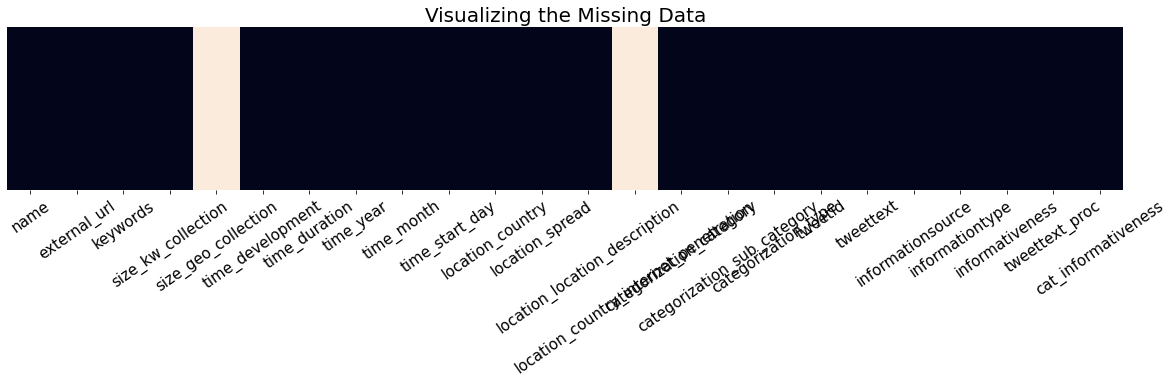

In [ ]:
plt.figure(figsize = (20, 3))
sn.heatmap(df_total.isna(), yticklabels = False, cbar = False)
plt.title("Visualizing the Missing Data", fontsize = 20)
plt.xticks(rotation = 35, fontsize = 15)
plt.show()

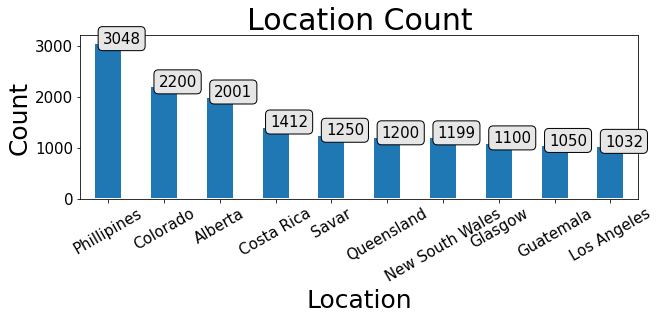

In [ ]:
plt.figure(figsize = (10, 3))
ax = plt.axes()
ax = ((df_total['location_location_description'].value_counts())[:10]).plot(kind = 'bar',  linewidth = 2, edgecolor = 'white')
plt.title('Location Count', fontsize = 30)
plt.xlabel('Location', fontsize = 25)
plt.ylabel('Count', fontsize = 25)
ax.xaxis.set_tick_params(labelsize = 15, rotation = 30)
ax.yaxis.set_tick_params(labelsize = 15)
bbox_args = dict(boxstyle = 'round', fc = '0.9')
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.15, p.get_height() + 2),
                   bbox = bbox_args,
                   fontsize = 15)

##  Train and Test Split

In [ ]:
crisis_for_test = ['Spain train crash', 'Italy earthquakes', 'Queensland Floods', 'Sardinia Floods']
df_test = df_total[df_total['name'].isin(crisis_for_test)]
df_train = df_total[~df_total['name'].isin(crisis_for_test)]
df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_test.to_csv('test_data.csv' , index=False, sep = 't')
df_train.to_csv('train_data.csv', index=False, sep = 't')

## Baseline Model: Filtering by characteristics

As a baseline approach we will use filtering by characteristics. The filtering by characteristics classifies the twitters searching for tweets with specific hashtags, keywords or location [[1]](https://elib.dlr.de/137213/1/2278_MattiWiegmann_etal2020.pdf). For this we will use the lexicon Crisis Lex, which is a list of more than 300 lexicons related to disasters [[7]](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/download/8091/8138).

In [ ]:
# fullpath= os.path.join(dirname, filename)

for dirname, _, filenames in os.walk("CrisisLexLexicon"):
    for filename in filenames:
        fullpath= os.path.join(dirname, filename)
        if fullpath.endswith('.txt'):
            list_crisislex = open(fullpath,'r').read().splitlines()
            break

In [ ]:
def baseline_model(list_crisislex, df_total):
    pattern = '|'.join(list_crisislex) 
    y_pred = df_total['tweettext_proc'].str.contains(pattern)
    return y_pred

In [ ]:
def evaluate(y_test, y_pred, trhold):
    """
    Evaluation function. For each of the text in evaluation data, it reads the score from
    the predictions made. And based on this, it calculates the values of
    True positive, True negative, False positive, and False negative.

    :param y_test: true labels
    :param y_pred: predicted labels
    :param labels: list of possible labels
    :return: evaluation metrics for classification like, precision, recall, and f_score
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    mauc = auc(fpr, tpr)

    y_pred  = np.where(y_pred > trhold, 1, 0) 
    labels = ['Not informative', 'Related and informative']
    confusion = confusion_matrix(y_test, y_pred)


    df_cm = pd.DataFrame(confusion, index=[i for i in labels],
                         columns=[i for i in labels])


    # importing accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    
    
    report = classification_report(y_test, y_pred, target_names = labels)
    print(report)
    return accuracy, precision, recall, f1score, mauc 


In [ ]:
for cat in df_test.categorization_type.unique():
    print(cat)
    tmp = df_test[df_test['categorization_type'] == cat]
    y_pred = baseline_model(list_crisislex, tmp)
    y_actual  = np.where(tmp.cat_informativeness =='Related and informative', True, False)
    accuracy, precision, recall, f1score, mauc = evaluate(y_actual, y_pred, 0.5)

Earthquake
                         precision    recall  f1-score   support

        Not informative       0.44      0.79      0.57       373
Related and informative       0.76      0.40      0.53       627

               accuracy                           0.55      1000
              macro avg       0.60      0.60      0.55      1000
           weighted avg       0.64      0.55      0.54      1000

Floods
                         precision    recall  f1-score   support

        Not informative       0.53      0.72      0.61       841
Related and informative       0.78      0.60      0.68      1359

               accuracy                           0.65      2200
              macro avg       0.65      0.66      0.64      2200
           weighted avg       0.68      0.65      0.65      2200

Derailment
                         precision    recall  f1-score   support

        Not informative       0.29      0.55      0.38       271
Related and informative       0.75      0.50      0.60

The baseline-filtering approach easily misses tweets that do not mention the keywords specified in advance, particularly when changes occur or the attention focus shifts during the event. 